In [1]:
%matplotlib inline

import pickle
import string

import matplotlib.pyplot as plt
import os
import math

from typing import Dict, List

In [2]:
def get_label(index: int, nouns: List[str]):
    if len(nouns) <= index:
        label = index
    else:
        label = nouns[index]
    return label

def alpha_to_int(alpha: List[int]):
    return int(alpha[0])*4 + int(alpha[1])*2 + int(alpha[2])

In [3]:
def plot_frac_alphas(dataset_name:str, dataset_path:str, nouns: Dict[int, str], alphas: Dict):
    alphas_file = open(f'{dataset_path}/alphas_{dataset_name}.pickle', 'rb')
    alphas_per_object = pickle.load(alphas_file)

    freqs = {}
    n_dets = 0
    n_correct_dets = 0
    for object_index, alphas_tmp in alphas_per_object.items():
        label = get_label(object_index, nouns)
        freqs[label] = sum([a == alphas[label] for a in alphas_tmp]) / len(alphas_tmp)
        max_frac = 0
        for alpha in [[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]:
            frac = sum([a == alpha for a in alphas_tmp]) / len(alphas_tmp)
            if max_frac < frac:
                max_frac = frac
        if freqs[label] >= max_frac:
            n_correct_dets += 1
        n_dets += 1
    print(f'{n_correct_dets / n_dets * 100.0}% of determiners were correct.')
    plt.bar(range(len(freqs)), list(freqs.values()), align='center', label='correct')
    plt.bar(range(len(freqs)), [1-x for x in list(freqs.values())], align='center', bottom=list(freqs.values()), label='incorrect')
    plt.plot([-0.5, len(freqs) - 0.5], [1.0/7.0, 1.0/7.0], label='Chance', color='green')
    plt.xticks(range(len(freqs)), list(freqs.keys()), rotation=90)    
    plt.xlabel('Determiner')
    plt.ylabel('Posterior Probabilitiy')
    plt.legend()
    plt.show()

In [4]:
def get_stats(alphas_per_object, nouns):
    freqs = {}
    n_dets = 0
    n_correct_dets = 0
    for object_index, alphas_tmp in alphas_per_object.items():
        if object_index in nouns:
            label = nouns[object_index]
        else:
            label = object_index
        freqs[label] = sum([a == alphas[label] for a in alphas_tmp]) / len(alphas_tmp)
        max_frac = 0
        for alpha in [[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]:
            frac = sum([a == alpha for a in alphas_tmp]) / len(alphas_tmp)
            if max_frac < frac:
                max_frac = frac
        if freqs[label] >= max_frac:
            n_correct_dets += 1
        n_dets += 1
    return freqs, n_correct_dets / n_dets

def compare_coropra(dataset1_name: str, dataset1_path: str, nouns1: Dict,
                    dataset2_name: str, dataset2_path: str, nouns2: Dict,
                    alphas, title: str):
    alphas1_file = open(f'{dataset1_path}/alphas_{dataset1_name}.pickle', 'rb')
    alphas1_per_object = pickle.load(alphas1_file)
    
    freqs1, frac_correct1 = get_stats(alphas1_per_object, nouns1)
    
    alphas2_file = open(f'{dataset2_path}/alphas_{dataset2_name}.pickle', 'rb')
    alphas2_per_object = pickle.load(alphas2_file)
    freqs2, frac_correct2 = get_stats(alphas2_per_object, nouns2)

    print(f'{frac_correct1 * 100.0}% of determiners were correct in L1.')
    print(f'{frac_correct2 * 100.0}% of determiners were correct in L2.')
    
    common_nouns = set(freqs1.keys()).intersection(freqs2.keys())
    
    bar_width = 2.0
    inner_gap = 1
    outer_gap = 3.0
    width = 2 * bar_width + inner_gap + outer_gap
 
    # set height of bar
    bars1 = []
    bars2 = []
    for noun in common_nouns:
        bars1 += [freqs1[noun]]
        bars2 += [freqs2[noun]]
    # Set position of bar on X axis
    base_range = [width * x for x in range(1, len(bars1)+1)]
    r1 = [x - (bar_width + inner_gap) / 2.0 for x in base_range]
    r2 = [x + (bar_width + inner_gap) / 2.0 for x in base_range]
    
    plt.figure(figsize=(10,4))
    plt.bar(r1, bars1, width=bar_width, label='correct', color='brown')
    plt.bar(r2, bars2, width=bar_width, color='brown')
    plt.bar(r1, [1-x for x in bars1], width=bar_width, bottom=bars1, label='incorrect', color='blue')
    plt.bar(r2, [1-x for x in bars2], width=bar_width, bottom=bars2, color='blue')
    plt.plot([min(base_range) - bar_width - inner_gap, max(base_range) + bar_width+inner_gap], [1/7] * 2, label='chance', color='green')
    plt.xticks(base_range, common_nouns, rotation=90)    
    plt.xlabel('Determiner')
    plt.ylabel('Posterior Probabilitiy')
    plt.legend()
    plt.title(title)    
    plt.show()

In [5]:
def plot_alphas(dataset_name: str,
                dataset_path: str,
                nouns: List[str],
                correct_alphas: Dict[str, List[int]]):
    alphas_file = open(f'{dataset_path}/alphas_{dataset_name}.pickle', 'rb')
    alphas_per_object = pickle.load(alphas_file)

    alphas_per_object_concat = dict()
    for object_index, alphas in alphas_per_object.items():
        for alpha in alphas:
            concat_alphas = alphas_per_object_concat.get(object_index, list())
            concat_alphas.append(alpha[0] * 4 + alpha[1] * 2 + alpha[2] - 1)
            alphas_per_object_concat[object_index] = concat_alphas

    for object_index, alphas in alphas_per_object_concat.items():
        N, bins, patches = plt.hist(alphas, bins=[0, 1, 2, 3, 4, 5, 6, 7], density=True)
        if object_index in nouns:
            label = nouns[object_index]
        else:
            label = object_index
        plt.title(f'Histogram of alphas for \'{label}\'')
        plt.xlabel('Alpha')
        plt.ylabel('Frequency')
        plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ["<0,0,1>","<0,1,0>","<0,1,1>","<1,0,0>","<1,0,1>","<1,1,0>","<1,1,1>"], rotation=90)
        
        if correct_alphas:
            correct_alpha = correct_alphas[label]
            alpha_val = alpha_to_int(correct_alpha)
            patches[alpha_val - 1].set_facecolor('g')
            patches[alpha_val - 1].set_label('Correct')
            if alpha_val is 1:
                patches[1].set_label('Incorrect')
            else:
                patches[0].set_label('Incorrect')
                
            plt.legend()
        plt.show()

def plot_epsilons(dataset_name: str,
                  dataset_path: str,
                  corpus_name: str):
    epsilons_file = open(f'{dataset_path}/epsilons_{dataset_name}.csv')
    epsilons_string = epsilons_file.readline().split(',')
    epsilons = [float(x) for x in epsilons_string]
    size = len(epsilons)

    plt.figure(figsize=(size / 100, 5))
    plt.title(f'Epsilon over time for the {corpus_name} dataset')
    plt.xlabel('Iteration')
    plt.ylabel('Epsilon')
    plt.plot(epsilons)
    plt.show()

    plt.title(f'Histogram of epsilon for the {corpus_name} dataset')
    plt.xlabel('Epsilon')
    plt.ylabel('Density')
    plt.hist(epsilons, bins=50, density=True)
    plt.show()

    plt.title(f'Histogram of epsilon for the {corpus_name} dataset after 10% burnin')
    plt.xlabel('Epsilon')
    plt.ylabel('Density')
    plt.hist(epsilons[int(size * 0.1):], bins=50, density=True)
    plt.show()

    plt.title(f'Histogram of epsilon for the {corpus_name} dataset after 90% burnin')
    plt.xlabel('Epsilon')
    plt.ylabel('Density')
    plt.hist(epsilons[int(size * 0.9):], bins=50, density=True)
    plt.show()
             
def plot_deltas(dataset_name: str,
                dataset_path: str,
                corpus_name: str):
    def plot_delta_i(i: str):
        delta_i_file = open(f'{dataset_path}/delta_{i}s_{dataset_name}.csv')
        delta_i_strings = delta_i_file.readline().split(',')
        delta_i = [float(x) for x in delta_i_strings]
        size = len(delta_i)


        plt.figure(figsize=(size / 100, 5))
        plt.title(f'Delta {i} over time for the {corpus_name} dataset')
        plt.xlabel('Iteration')
        plt.ylabel('Delta')
        plt.plot(delta_i)
        plt.show()

        plt.title(f'Histogram of delta {i} for the {corpus_name} dataset')
        plt.xlabel(f'Delta {i}')
        plt.ylabel('Density')
        plt.hist(delta_i, bins=50, density=True)
        plt.show()

        plt.title(f'Histogram of delta {i} for the {corpus_name} dataset after 10% burnin')
        plt.xlabel(f'Delta {i}')
        plt.ylabel('Density')
        plt.hist(delta_i[int(size * 0.1):], bins=50, density=True)
        plt.show()

        plt.title(f'Histogram of delta {i} for the {corpus_name} dataset after 90% burnin')
        plt.xlabel(f'Delta {i}')
        plt.ylabel('Density')
        plt.hist(delta_i[int(size * 0.9):], bins=50, density=True)
        plt.show()
        
    plot_delta_i('one')
    plot_delta_i('two')
    plot_delta_i('three')

def plot_dataset(dataset_name: str,
                 dataset_path: str,
                 nouns: List[str],
                 correct_alphas: Dict = None,
                 corpus_name = '',
                 comment: str = ''):
    print(f'Analysis of {dataset_name}')
    print()
    print(comment)
    print()
    
    # Likelyhood
    if os.path.isfile(f'{dataset_path}/likelyhoods_{dataset_name}.csv'):
        print(f'Log likelyhood over time for {dataset_name} dataset')
        log_likelyhood_file = open(f'{dataset_path}/likelyhoods_{dataset_name}.csv')
        likelyhood_strings = log_likelyhood_file.readline().split(',')
        likelyhood = [float(x) for x in likelyhood_strings]
        size = len(likelyhood)

        plt.figure(figsize=(size / 20, 5))
        plt.plot(likelyhood)
        plt.title("Sampled Value log-Likelyhood over Time")
        plt.xlabel("10 Iterations")
        plt.ylabel("log-Likelyhood")
        plt.show()

    # Alphas
    print(f'Alphas for the {dataset_name} dataset')
    plot_alphas(dataset_name, dataset_path, nouns, correct_alphas)
    
    # Epsilons
    print(f'Epsilons for the {dataset_name} dataset')
    plot_epsilons(dataset_name, dataset_path, corpus_name)

    # Deltas
    print(f'Delta ones for the {dataset_name} dataset')
    plot_deltas(dataset_name, dataset_path, corpus_name)

In [6]:
efcamdat_dets = open('./data/efcamdat/dets.txt', 'r').readlines()
efcamdat_dets = [det[:-1] for det in efcamdat_dets]

efcamdat_dets_no_cardinals = open('../data/efcamdat/dets_no_cardinals.txt', 'r').readlines()
efcamdat_dets_no_cardinals = [det[:-1] for det in efcamdat_dets_no_cardinals]

efcamdat_common_dets = open('../data/efcamdat/common_dets.txt', 'r').readlines()
efcamdat_common_dets = [det[:-1] for det in efcamdat_common_dets]

wiki_dets = open('../data/wikipedia/dets.txt', 'r').readlines()
wiki_dets = [det[:-1] for det in wiki_dets]

enron_dets = open('../data/enron/dets.txt', 'r').readlines()
enron_dets = [det[:-1] for det in enron_dets]

enron_common_dets = open('../data/enron/common_dets.txt', 'r').readlines()
enron_common_dets = [det[:-1] for det in enron_common_dets]

FileNotFoundError: [Errno 2] No such file or directory: '../data/efcamdat/dets.txt'

In [8]:
def list_to_dict(l):
    out = {}
    for i, item in enumerate(l):
        out[i] = item
    return out

In [148]:
alphas_file = open('../data/alphas.txt' ,'r')
alphas_file.readline()
alphas = {}
for line in alphas_file.readlines():
    det, alpha_1, alpha_2, alpha_3 = line.split(',')
    alphas[det] = [int(alpha_1 == '1'), int(alpha_2  == '1'), int(alpha_3.strip()  == '1')]

# Differences in Noise

In [94]:
efcamdat_counts_file = open('../data/efcamdat/counts/det_cat_counts_efcamdat_clean.csv')
efcamdat_counts_file.readline()
efcamdat_counts = {}
efcamdat_fracs = {}
efcamdat_total_count = 0
for line in efcamdat_counts_file.readlines():
    det, c1, c2, c3, total = line.split(',')
    c1 = int(c1)
    c2 = int(c2)
    c3 = int(c3)
    total = int(total)
    if total > 10:
        efcamdat_counts[det] = [c1, c2, c3]
        efcamdat_fracs[det] = [c1 / total, c2 / total, c3 / total]
        efcamdat_total_count += total
        
    
enron_counts_file = open('../data/enron/counts/det_cat_counts_clean_enron.csv')
enron_counts_file.readline()
enron_counts = {}
enron_fracs = {}
enron_total_count= 0
for line in enron_counts_file.readlines():
    det, c1, c2, c3, total = line.split(',')
    c1 = int(c1)
    c2 = int(c2)
    c3 = int(c3)
    total = int(total)
    if total > 10:
        enron_counts[det] = [c1, c2, c3]
        enron_fracs[det] = [c1 / total, c2 / total, c3 / total]
        enron_total_count += total

In [95]:
noise_usage_fracs_l1 = list()
noise_usage_fracs_l2 = list()

noise_usage_counts_l1 = list()
noise_usage_counts_l2 = list()
for det in alphas:
    alpha = alphas[det]
    for i in range(3):
        if not alpha[i]:
            if det in enron_fracs:
                noise_usage_fracs_l1.append(enron_fracs[det][i])
                noise_usage_counts_l1.append(enron_counts[det][i])
            if  det in efcamdat_fracs:
                noise_usage_fracs_l2.append(efcamdat_fracs[det][i])
                noise_usage_counts_l2.append(efcamdat_counts[det][i])

Average Noise Fraction: 0.04699252037595533


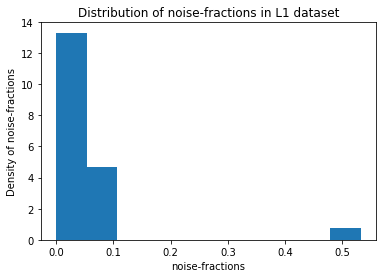

Average Noise Fraction: 0.1946786739157949


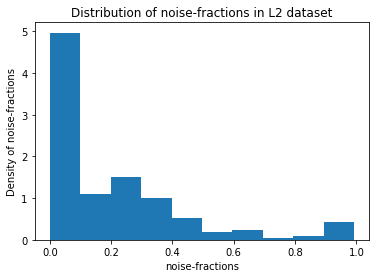

Frac of noise counts: 0.009642232272658197


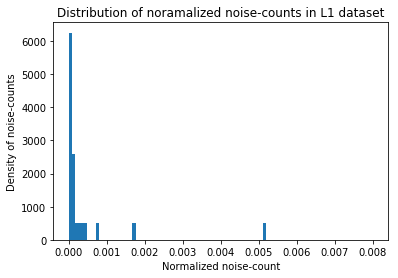

Frac of noise counts: 0.052496988157206825


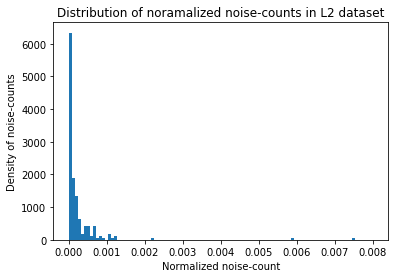

In [96]:
print(f'Average Noise Fraction: {sum(noise_usage_fracs_l1) / len(noise_usage_fracs_l1)}')

plt.hist(noise_usage_fracs_l1, density=True)
plt.title("Distribution of noise-fractions in L1 dataset")
plt.ylabel("Density of noise-fractions")
plt.xlabel("noise-fractions")
plt.show()

print(f'Average Noise Fraction: {sum(noise_usage_fracs_l2) / len(noise_usage_fracs_l2)}')

plt.hist(noise_usage_fracs_l2, density=True)
plt.title("Distribution of noise-fractions in L2 dataset")
plt.ylabel("Density of noise-fractions")
plt.xlabel("noise-fractions")
plt.show()

print(f'Frac of noise counts: {sum(noise_usage_counts_l1) / enron_total_count}')

plt.hist([count / enron_total_count for count in noise_usage_counts_l1], density=True, bins=100, range=(0,0.008))
plt.title("Distribution of noramalized noise-counts in L1 dataset")
plt.ylabel("Density of noise-counts")
plt.xlabel("Normalized noise-count")
plt.show()

print(f'Frac of noise counts: {sum(noise_usage_counts_l2) / efcamdat_total_count}')

plt.hist([count / efcamdat_total_count for count in noise_usage_counts_l2], density=True, bins=100, range=(0,0.008))
plt.title("Distribution of noramalized noise-counts in L2 dataset")
plt.ylabel("Density of noise-counts")
plt.xlabel("Normalized noise-count")
plt.show()

# Full Results

Analysis of log_5000_common

L2 learner data log-downsampled to 5000 total observations.

Log likelyhood over time for log_5000_common dataset


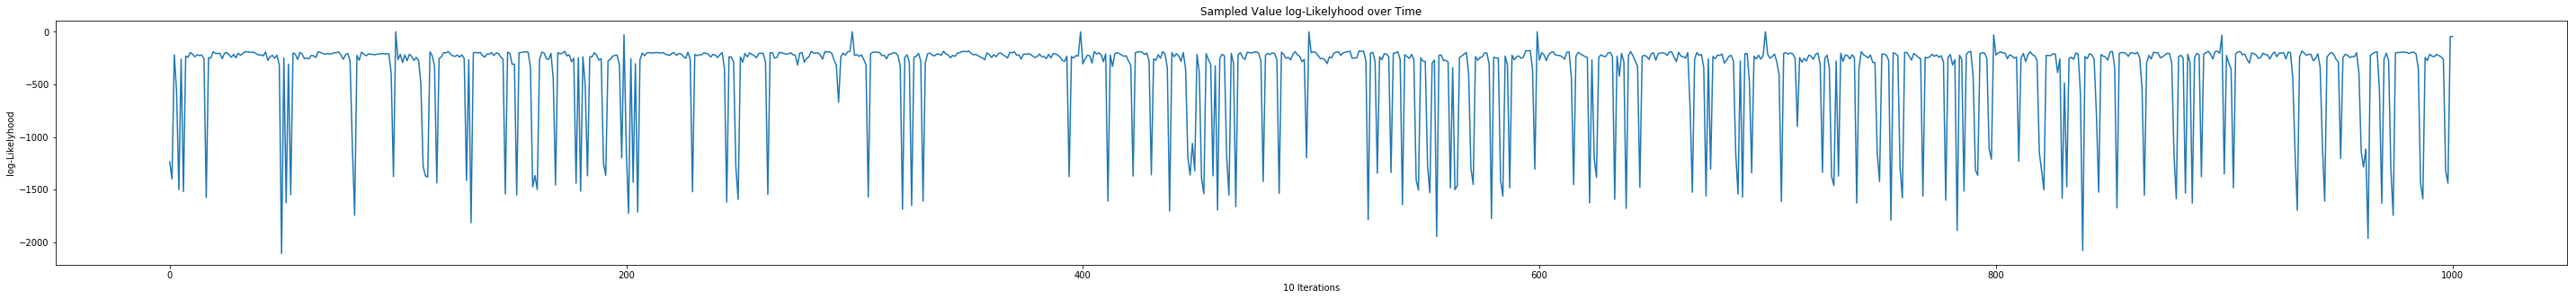

Alphas for the log_5000_common dataset


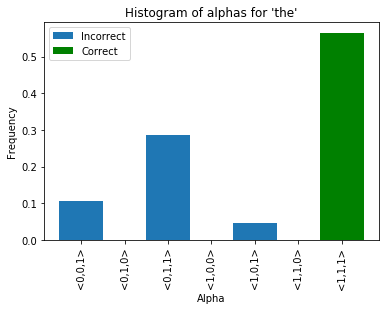

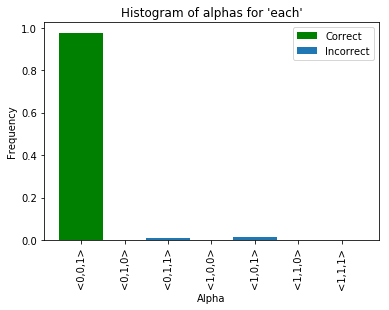

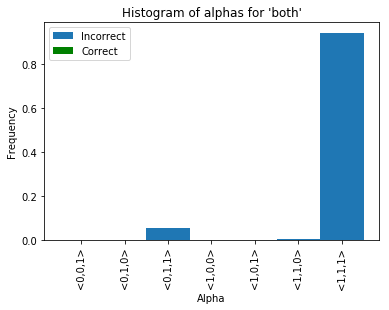

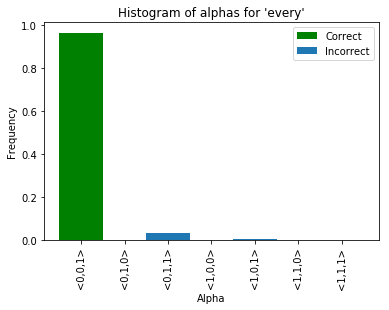

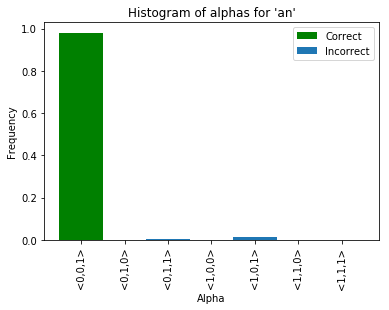

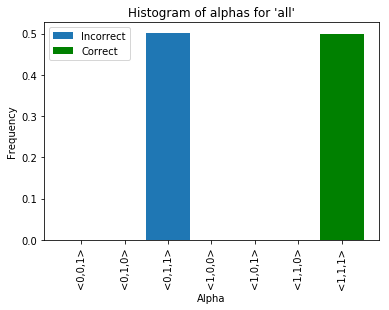

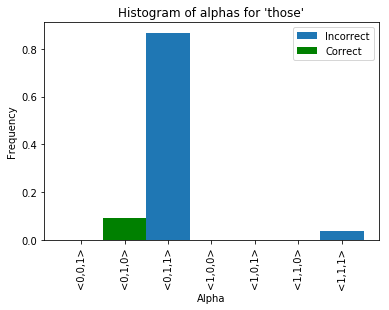

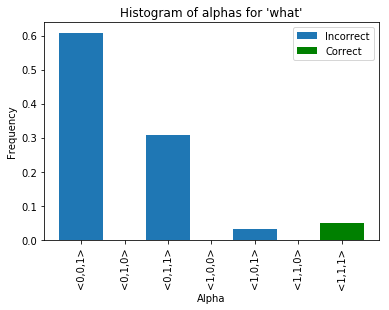

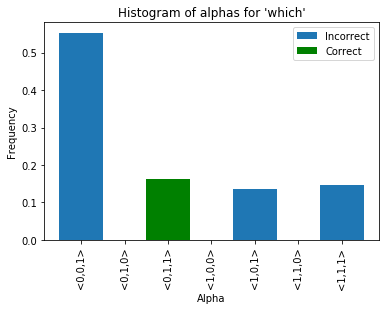

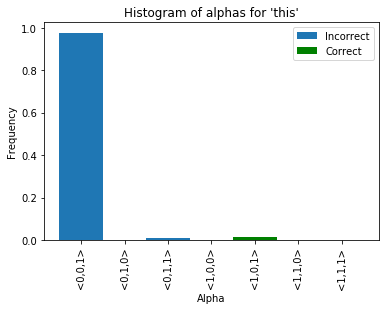

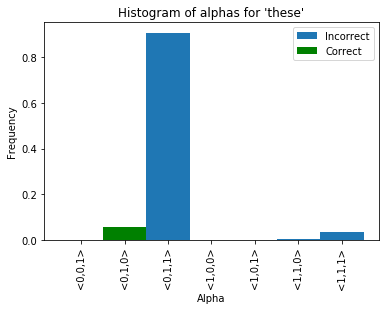

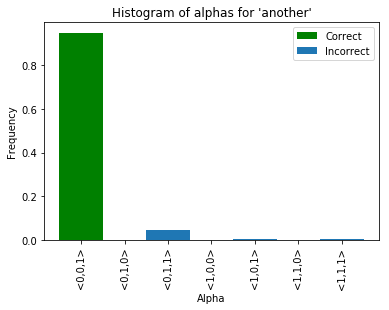

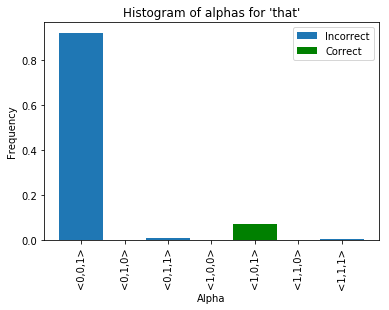

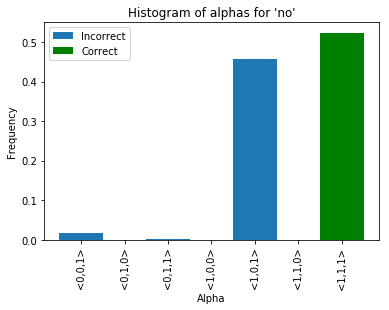

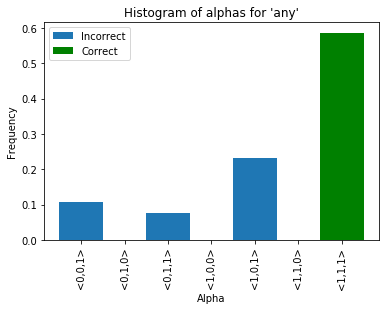

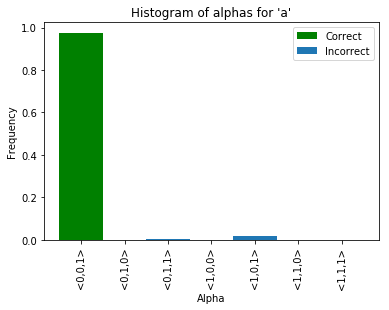

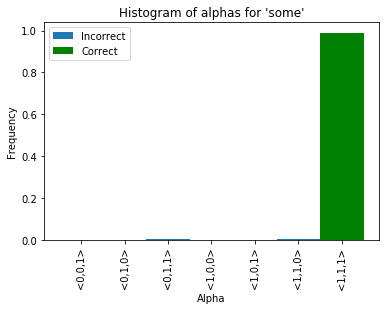

Epsilons for the log_5000_common dataset


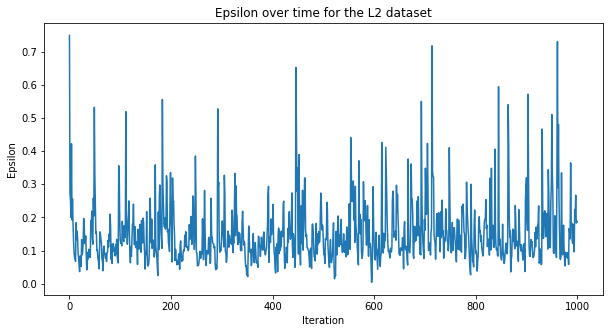

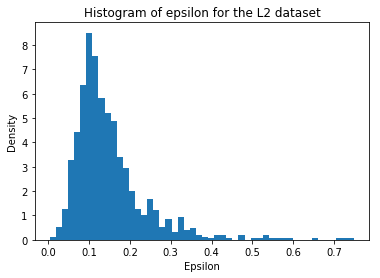

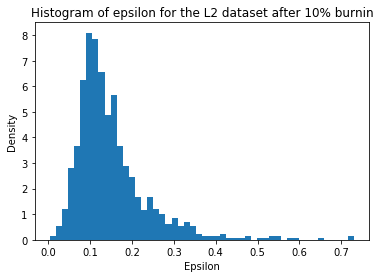

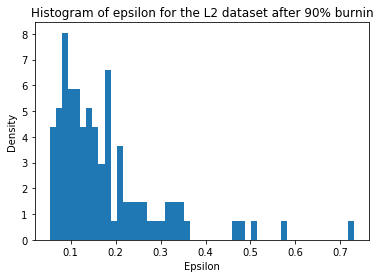

Delta ones for the log_5000_common dataset


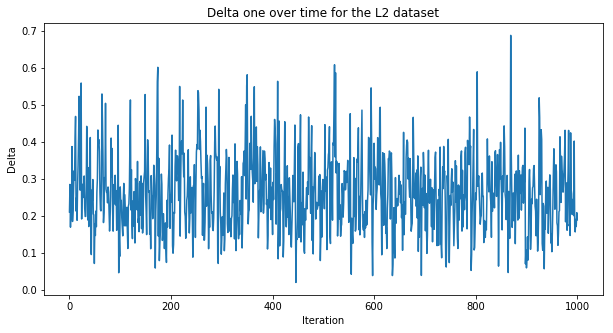

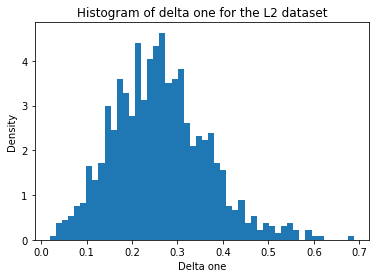

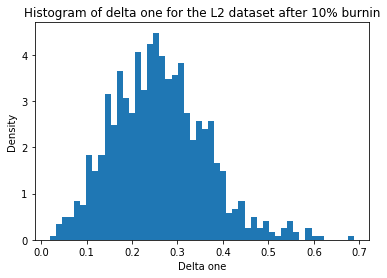

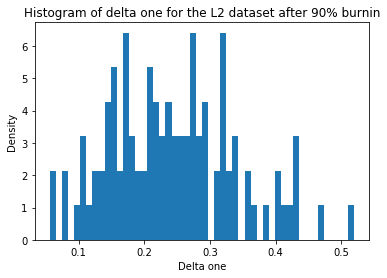

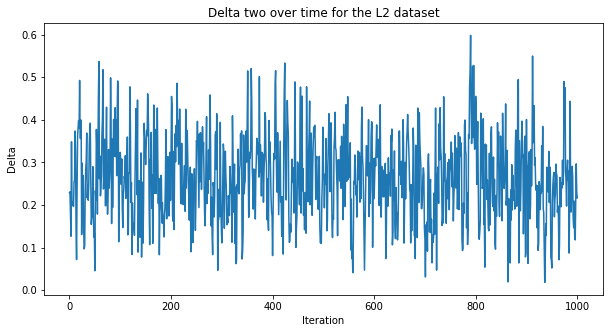

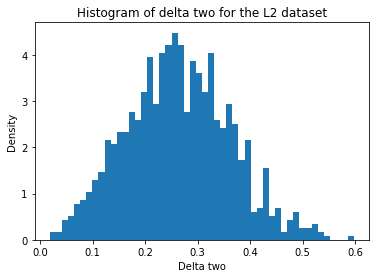

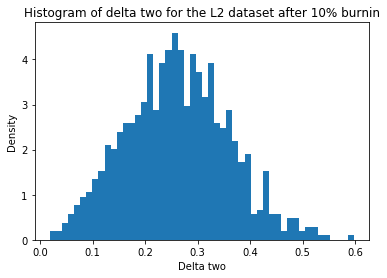

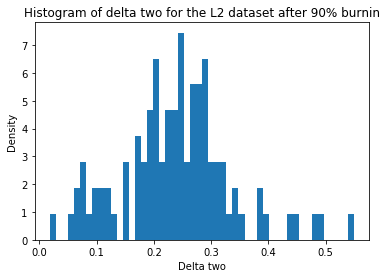

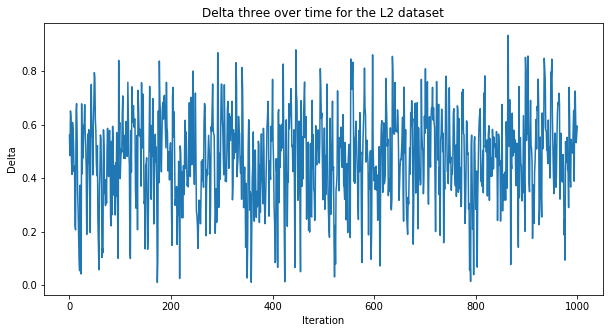

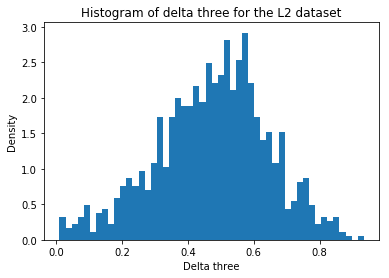

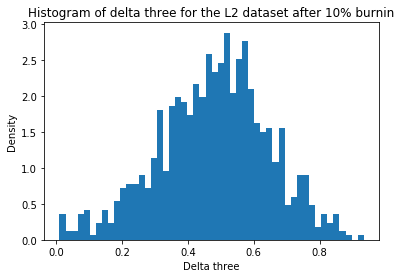

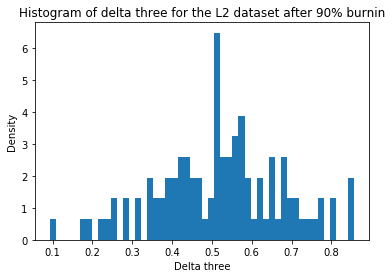

In [183]:
plot_dataset('log_5000_common', '../output/efcamdat/generated', list_to_dict(efcamdat_common_dets), alphas, 'L2', 'L2 learner data log-downsampled to 5000 total observations.')

52.94117647058824% of determiners were correct.


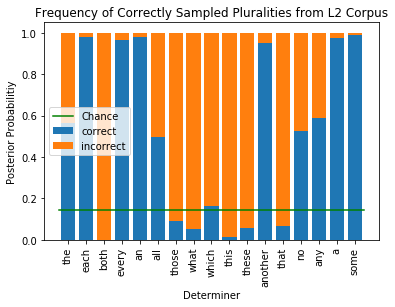

In [139]:
plt.title('Frequency of Correctly Sampled Pluralities from L2 Corpus')
plot_frac_alphas('log_5000_common', '../output/efcamdat/generated', list_to_dict(efcamdat_common_dets), alphas)

Analysis of log_5000_common

L1 learner data log-downsampled to 5000 total observations.

Log likelyhood over time for log_5000_common dataset


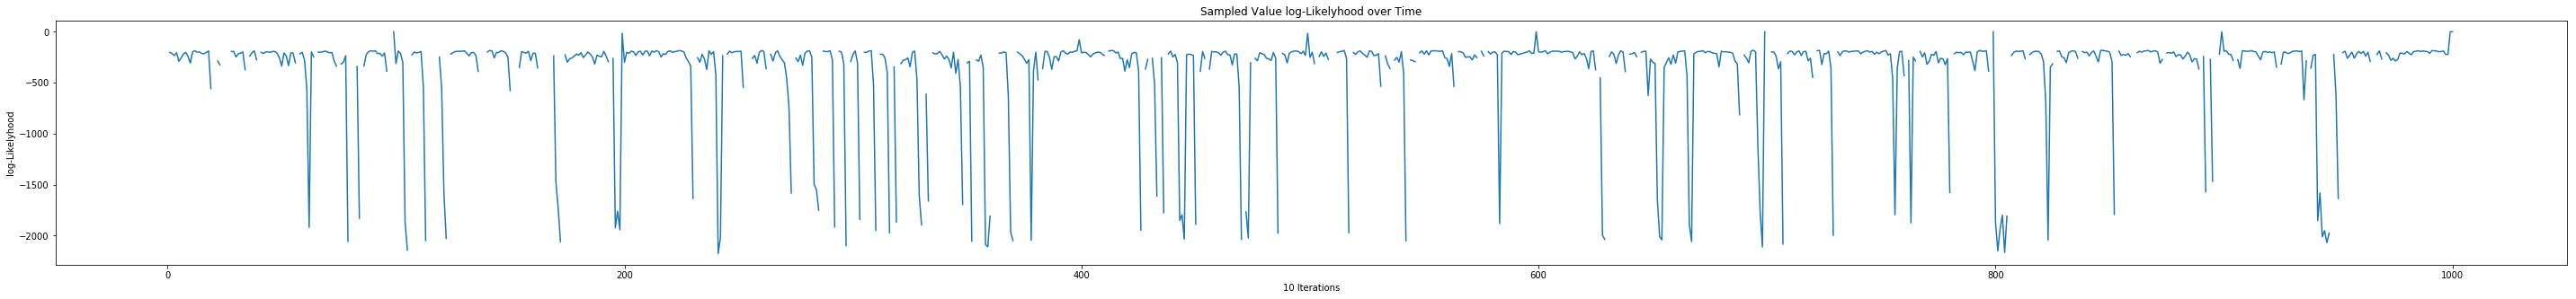

Alphas for the log_5000_common dataset


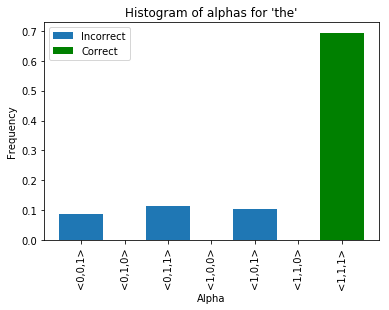

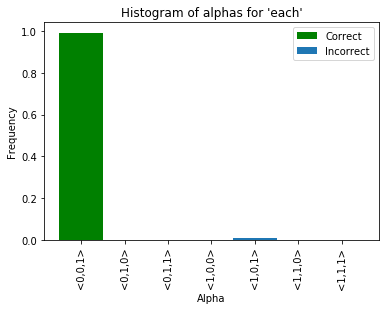

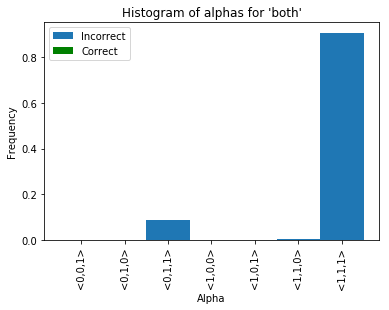

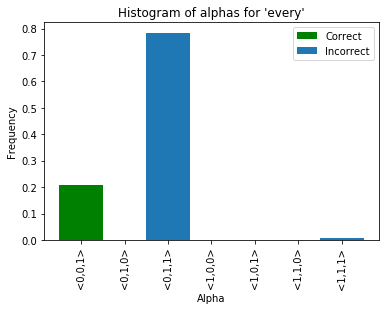

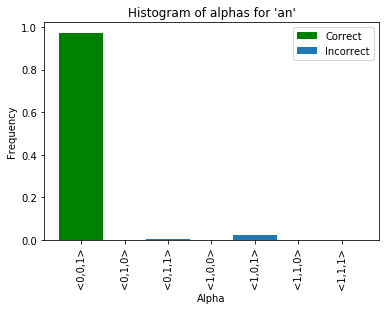

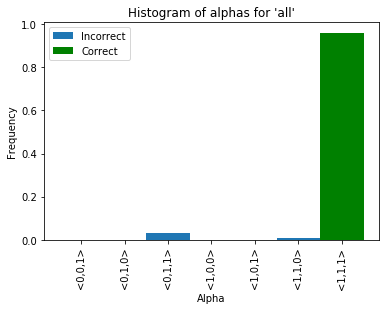

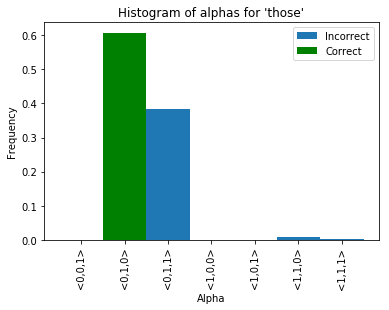

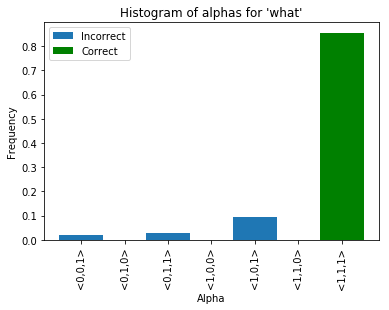

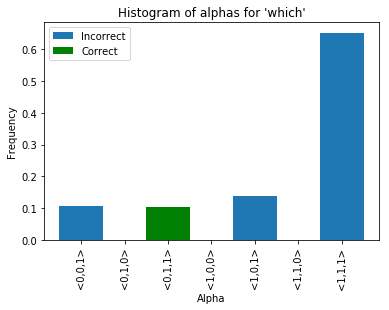

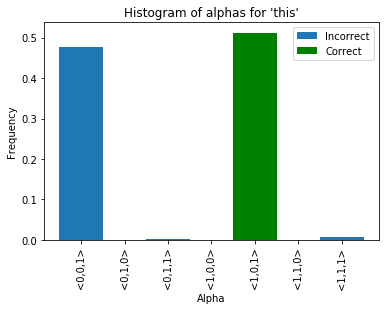

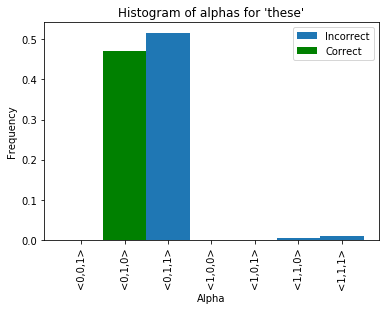

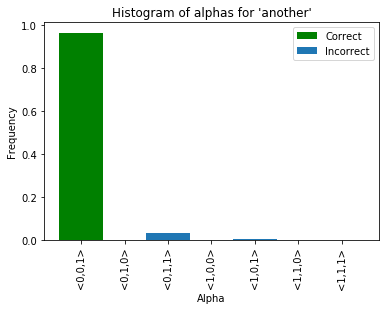

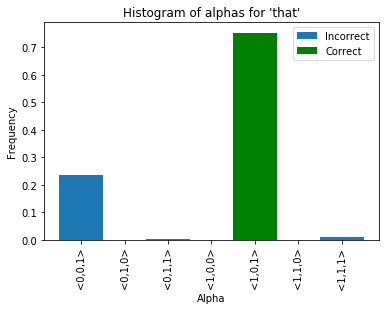

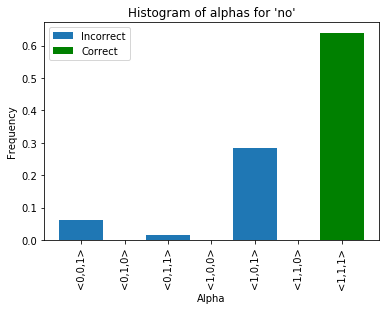

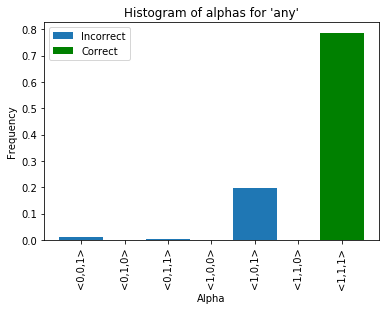

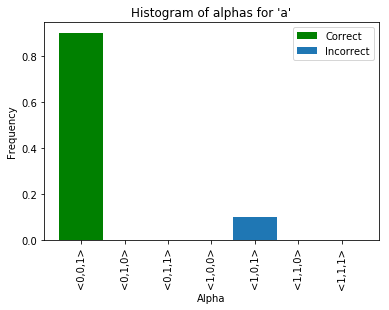

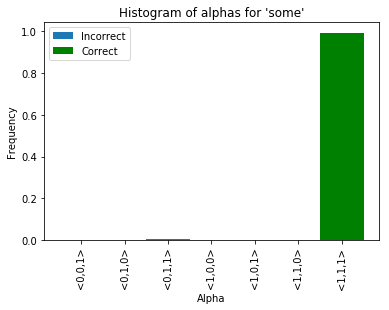

Epsilons for the log_5000_common dataset


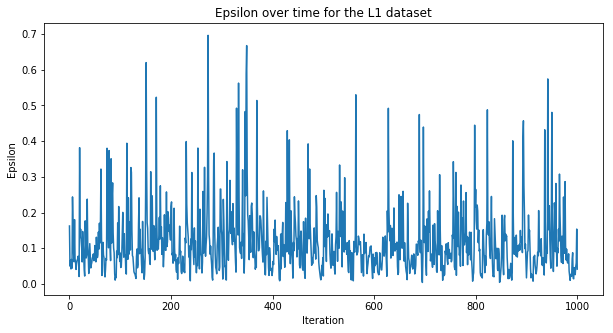

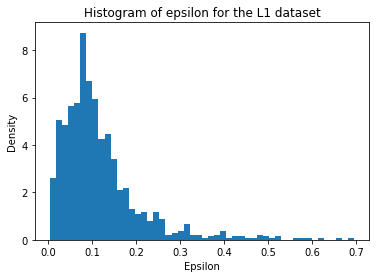

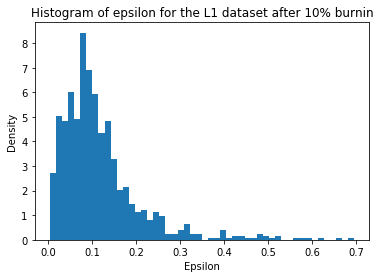

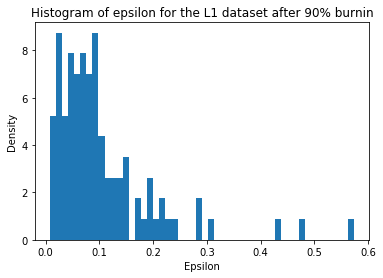

Delta ones for the log_5000_common dataset


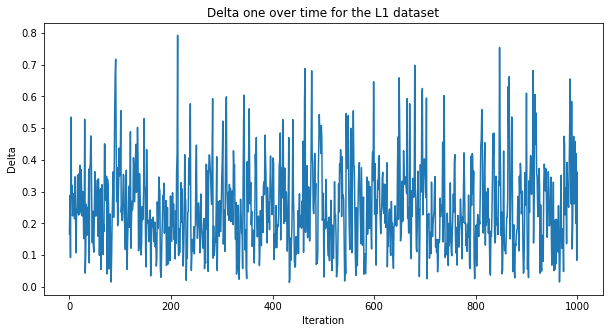

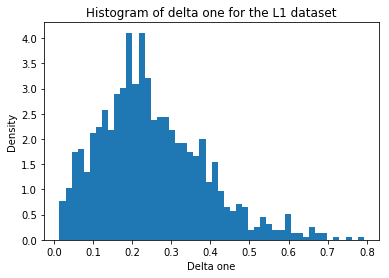

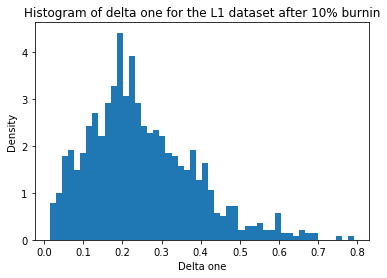

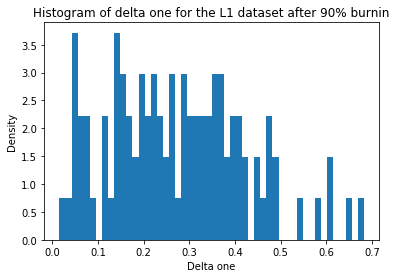

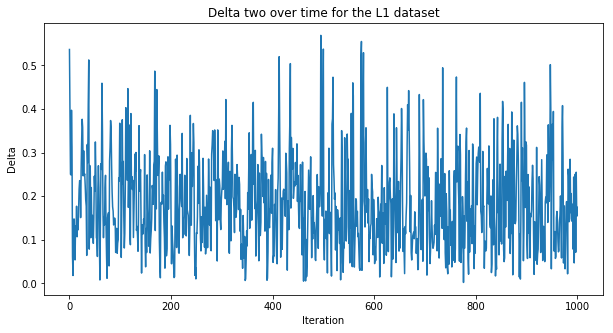

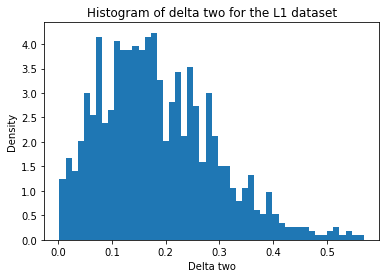

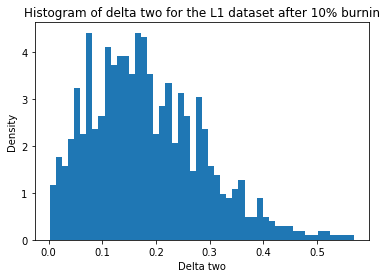

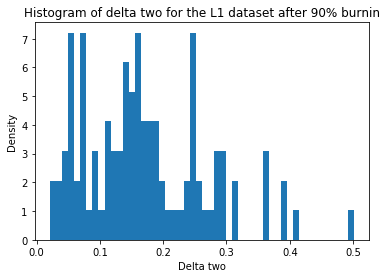

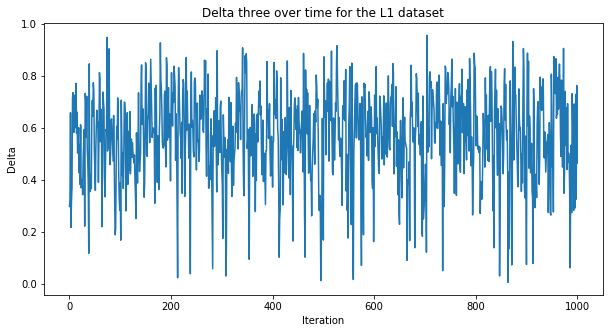

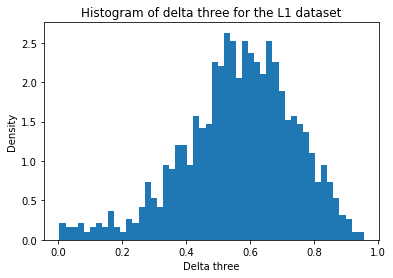

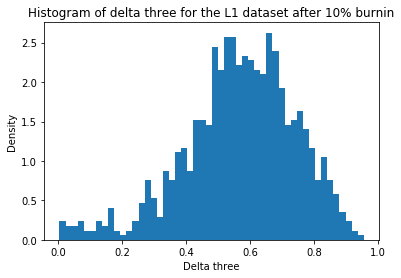

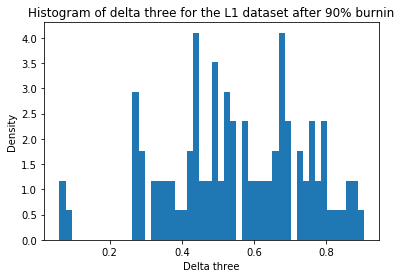

In [173]:
plot_dataset('log_5000_common', '../output/enron/generated', list_to_dict(enron_common_dets), alphas, 'L1', 'L1 learner data log-downsampled to 5000 total observations.')

# Comparisons

50.0% of determiners were correct in L1.
61.76470588235294% of determiners were correct in L2.


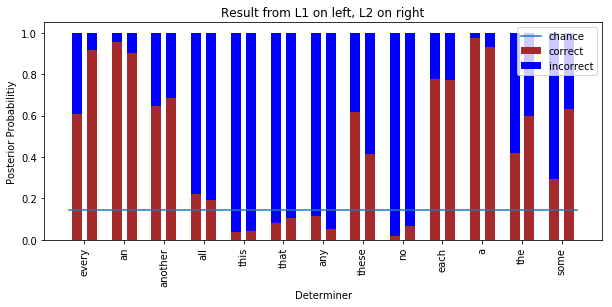

In [16]:
# Basically, non-logged is garbage
compare_coropra('downsampled_to_1000', '../output/enron/generated', list_to_dict(enron_dets),
                'downsampled_to_1000', '../output/efcamdat/generated', list_to_dict(efcamdat_dets),
                alphas, "Result from L1 on left, L2 on right")

75.0% of determiners were correct in L1.
52.63157894736842% of determiners were correct in L2.


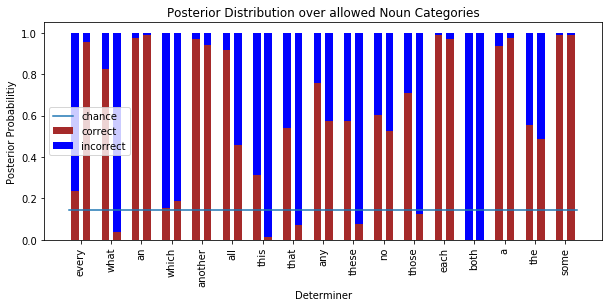

In [17]:
# L1 logged is pretty good but L2 logged is pretty bad.
# 50% is still way above chance (1 in 7 = 14%) but also isn't great
compare_coropra('log_5000_all', '../output/enron/generated', list_to_dict(enron_dets),
                'log_5000_no_cards', '../output/efcamdat/generated', list_to_dict(efcamdat_dets_no_cardinals),
                alphas, "Posterior Distribution over allowed Noun Categories")

76.47058823529412% of determiners were correct in L1.
52.94117647058824% of determiners were correct in L2.


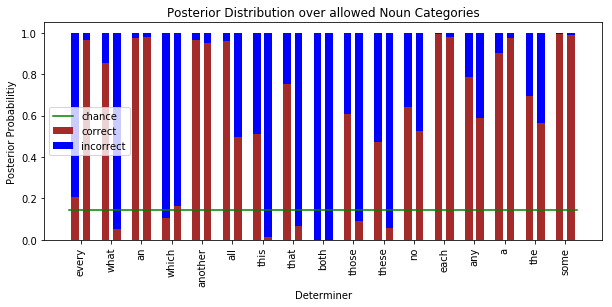

In [141]:
# L1 logged is pretty good but L2 logged is pretty bad.
# 50% is still way above chance (1 in 7 = 14%) but also isn't great
compare_coropra('log_5000_common', '../output/enron/generated', list_to_dict(enron_common_dets),
                'log_5000_common', '../output/efcamdat/generated', list_to_dict(efcamdat_common_dets),
                alphas, "Posterior Distribution over allowed Noun Categories")

52.63157894736842% of determiners were correct in L1.
52.94117647058824% of determiners were correct in L2.


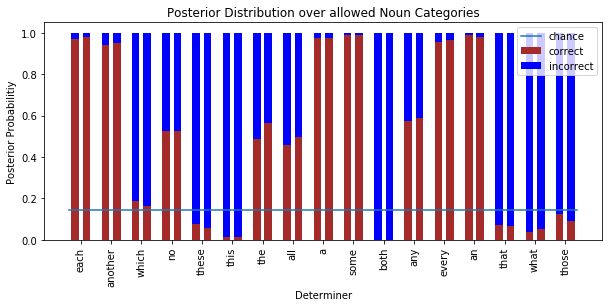

In [116]:
# Why are things so much worse when we restrict to common when that only
# removes 'mult' and 'one'?
# 'L1' is no_cards, 'L2' is common
compare_coropra('log_5000_no_cards', '../output/efcamdat/generated', list_to_dict(efcamdat_dets_no_cardinals),
                'log_5000_common', '../output/efcamdat/generated', list_to_dict(efcamdat_common_dets),
                alphas, "Posterior Distribution over allowed Noun Categories")

# Fering Comparison

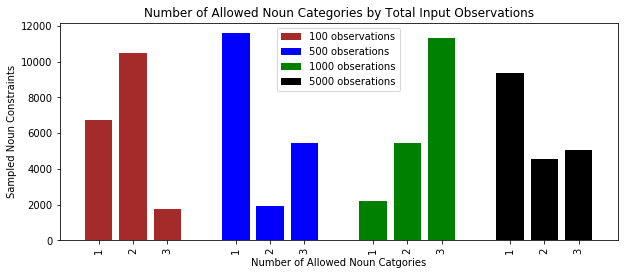

In [144]:
# Let's compute histogram of number of 1s per dataset
def compute_ones(dataset_name: str, dataset_path: str):
    n_ones = {}
    with open(f'{dataset_path}/alphas_{dataset_name}.pickle', 'rb') as alphas_file:
        alphas_per_object = pickle.load(alphas_file)
        for _, sampled_alphas in alphas_per_object.items():
            for alpha in sampled_alphas:
                ones = sum(alpha)
                n_ones[ones] = n_ones.get(ones, 0) + 1
    return n_ones

def plot_ones():
    plt.figure(figsize=(10,4))
    plt.bar(range(3), compute_ones('log_100_no_cards', '../output/efcamdat/generated').values(), color='brown', label='100 observations')
    plt.bar(range(4,7), compute_ones('log_500_no_cards', '../output/efcamdat/generated').values(), color='blue', label='500 obserations')
    plt.bar(range(8,11), compute_ones('log_1000_no_cards', '../output/efcamdat/generated').values(), color='green', label='1000 obserations')
    plt.bar(range(12,15), compute_ones('log_5000_no_cards', '../output/efcamdat/generated').values(), color='black', label='5000 obserations')

    plt.xticks([0,1,2,4,5,6,8,9,10,12,13,14], ['1','2','3']*4, rotation=90)    
    plt.xlabel('Number of Allowed Noun Catgories')
    plt.ylabel('Sampled Noun Constraints')
    plt.title('Number of Allowed Noun Categories by Total Input Observations')
    plt.legend()
    plt.show()

plot_ones()

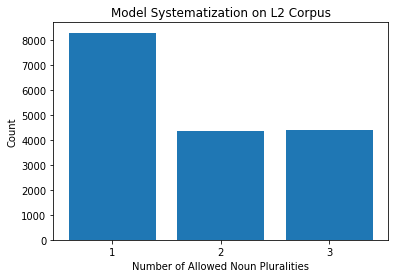

0.7420588235294118


In [164]:
plt.bar(range(3), compute_ones('log_5000_common', '../output/efcamdat/generated').values())
plt.xlabel('Number of Allowed Noun Pluralities')
plt.ylabel('Count')
plt.title('Model Systematization on L2 Corpus')
plt.xticks(range(3), [1,2,3])
plt.show()
ones = compute_ones('log_5000_common', '../output/efcamdat/generated')
print((ones[1] + ones[2]) / sum(ones.values()))

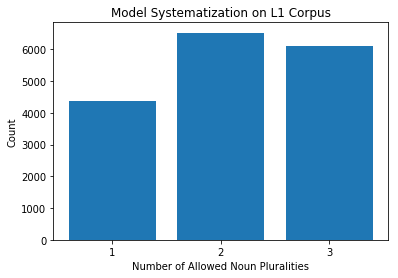

0.6162941176470588


In [165]:
plt.bar(range(3), compute_ones('log_5000_common', '../output/enron/generated').values())
plt.xlabel('Number of Allowed Noun Pluralities')
plt.ylabel('Count')
plt.title('Model Systematization on L1 Corpus')
plt.xticks(range(3), [1,2,3])
plt.show()
ones = compute_ones('log_5000_common', '../output/enron/generated')
print((ones[1] + ones[2]) / sum(ones.values()))

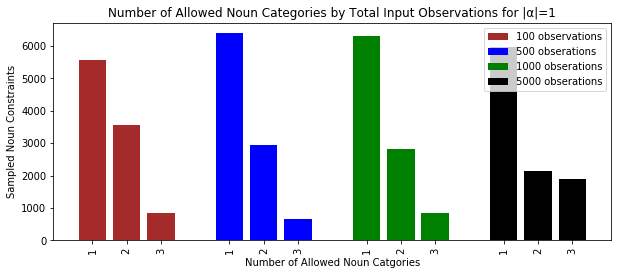

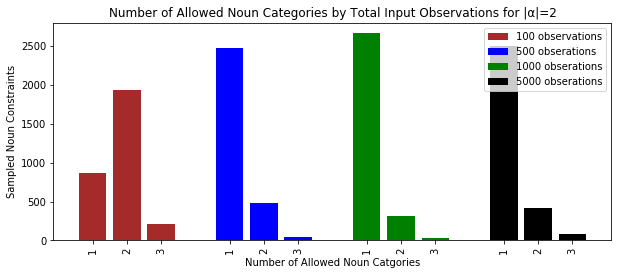

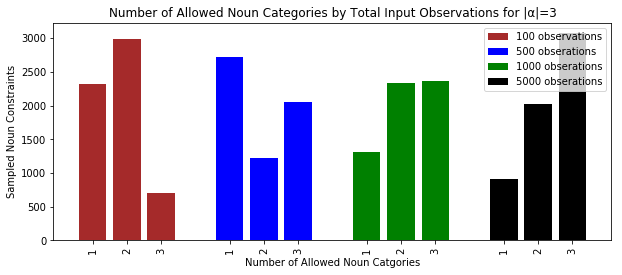

In [166]:
def compute_ones_for_n(dataset_name: str, dataset_path: str, nouns: Dict[int, str], alphas: Dict, n):
    n_ones = {}
    with open(f'{dataset_path}/alphas_{dataset_name}.pickle', 'rb') as alphas_file:
        alphas_per_object = pickle.load(alphas_file)
        for object_index, sampled_alphas in alphas_per_object.items():
            label = get_label(object_index, nouns)
            if sum(alphas[label]) == n:
                for alpha in sampled_alphas:
                    ones = sum(alpha)
                    n_ones[ones] = n_ones.get(ones, 0) + 1
    return n_ones

def plot_ones_for_n(n=3):
    plt.figure(figsize=(10,4))
    plt.bar(range(3), compute_ones_for_n('log_100_no_cards', '../output/efcamdat/generated', efcamdat_dets_no_cardinals, alphas, n).values(), color='brown', label='100 observations')
    plt.bar(range(4,7), compute_ones_for_n('log_500_no_cards', '../output/efcamdat/generated', efcamdat_dets_no_cardinals, alphas, n).values(), color='blue', label='500 obserations')
    plt.bar(range(8,11), compute_ones_for_n('log_1000_no_cards', '../output/efcamdat/generated', efcamdat_dets_no_cardinals, alphas, n).values(), color='green', label='1000 obserations')
    plt.bar(range(12,15), compute_ones_for_n('log_5000_no_cards', '../output/efcamdat/generated', efcamdat_dets_no_cardinals, alphas, n).values(), color='black', label='5000 obserations')

    plt.xticks([0,1,2,4,5,6,8,9,10,12,13,14], ['1','2','3']*4, rotation=90)    
    plt.xlabel('Number of Allowed Noun Catgories')
    plt.ylabel('Sampled Noun Constraints')
    plt.title(f'Number of Allowed Noun Categories by Total Input Observations for |α|={n}')
    plt.legend()
    plt.show()

plot_ones_for_n(1)
plot_ones_for_n(2)
plot_ones_for_n(3)